In [1]:
#-----------------#
# IMPORT PACKAGES #
#-----------------#
%matplotlib widget

import numpy as np
import os
import matplotlib
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import pandas as pd
from matplotlib.pyplot import cm
import tqdm
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
# Set MPL style
plt.style.use('default')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 100


import matplotlib.colors as colors
# This is a function from StackOverflow which takes a MPL colormap and can cuts off a defined amount
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

working_plasma = cmap = plt.get_cmap('plasma')
working_plasma = truncate_colormap(working_plasma, 0, 0.8)

In [3]:
# Define parts of file location
parent_directory = '/Users/michaeldawson/Documents/GitHub/Research/TestBatches'

# batch_name = '2022-03-29--15-12-58--Alg4RPi' # RPi Q-table Training 
# batch_name = '2022-03-30--17-24-29--Alg4RPi2'

# batch_name = '2022-03-29--15-12-42--Alg4Nano' # Nano Q-table Training
batch_name = '2022-03-31--11-21-05--Alg4Nano2'


# Combine parts of file location
batch_path = os.path.join(parent_directory,batch_name)
batch_data = pd.read_csv(os.path.join(batch_path,"batch_data.csv"),index_col=0)
device = batch_data['device'][0]

vis_path = '/Users/michaeldawson/Documents/GitHub/Research/Visuals'

In [4]:
df = pd.read_csv(os.path.join(batch_path, 'alg4/Strat_0/q_table.csv'), index_col=False)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
display(df.iloc[[1000]].to_numpy()[0][3:])

array([0., 0., 0., 0.])

In [5]:
working_q_table = df.drop(df[df.iloc[:, [3, 4, 5, 6]].max(axis=1)==df.iloc[:, [3, 4, 5, 6]].min(axis=1)].index)
display(working_q_table)

vis_q_table = pd.DataFrame(working_q_table[['Temperature','Pause Duration', 'Network']])
# for i, row in q_tables[device].iterrows() :
    # if row[3:].max() == row[3:].min() :
        # row[3:] = row[3:].replace([])
        
vis_q_table_pivot = {}                                                
vis_q_table['Action'] = working_q_table[['Nothing','Downgrade','Upgrade','Adjust']].idxmax(axis=1)
vis_q_table = vis_q_table.replace(['Nothing','Downgrade','Upgrade','Adjust'],[1,2,3,4])
vis_q_table_pivot[1] = vis_q_table.pivot(index='Temperature', columns=['Network', 'Pause Duration'], values='Action')
vis_q_table_pivot[2] = vis_q_table.pivot(index='Pause Duration', columns=['Network', 'Temperature'], values='Action')
vis_q_table_pivot[3] = vis_q_table.pivot(index='Network', columns=['Temperature', 'Pause Duration'], values='Action')


,Temperature,Pause Duration,Network,Nothing,Downgrade,Upgrade,Adjust
7000,42.0,0.0,0.0,-37.727640,-37.098000,-46.693951,0.000000
7500,42.5,0.0,0.0,-120.523432,-122.430062,-117.114972,-146.159262
8000,43.0,0.0,0.0,-289.782264,-276.633487,-294.014009,-280.260087
8500,43.5,0.0,0.0,-328.600709,-322.840967,-319.637165,-336.541792
9000,44.0,0.0,0.0,-361.690477,-361.008994,-357.161508,-362.740940
...,...,...,...,...,...,...,...
257901,52.5,0.1,4.0,0.000000,0.000000,0.000000,-8.250000
257912,52.5,1.2,4.0,0.000000,-9.600000,0.000000,0.000000
258400,53.0,0.0,4.0,-5.850000,-5.850000,-8.989000,0.000000
258412,53.0,1.2,4.0,0.000000,0.000000,-5.850000,0.000000


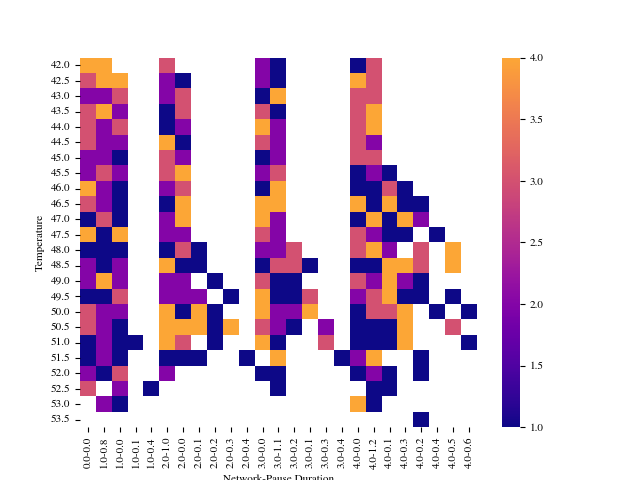

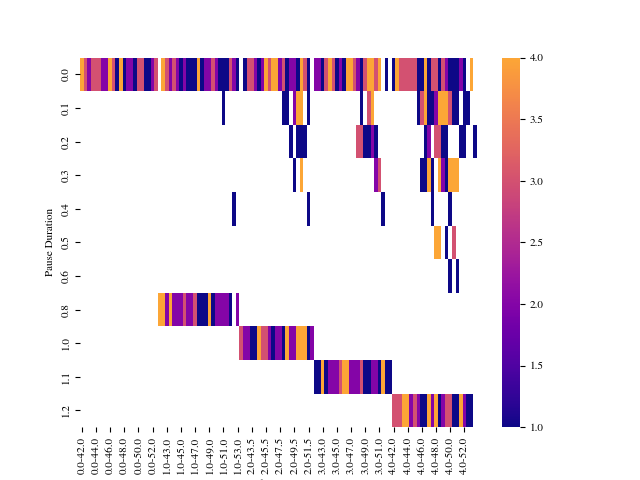

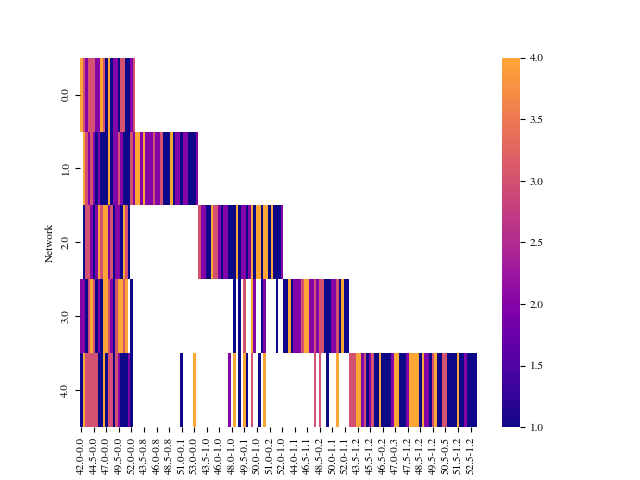

In [6]:
for i in range(1,4) :  
    plt.figure()
    sns.heatmap(vis_q_table_pivot[i], cmap=working_plasma)
    plot_path = os.path.join(batch_path, "Policy-Map-{}--Device-{}.png".format(i, device))
    plt.savefig(plot_path,bbox_inches="tight")

    plot_path = os.path.join(vis_path, "Policy-Map-{}--Device-{}.png".format(i, device))
    plt.savefig(plot_path,bbox_inches="tight")
    plt.show()

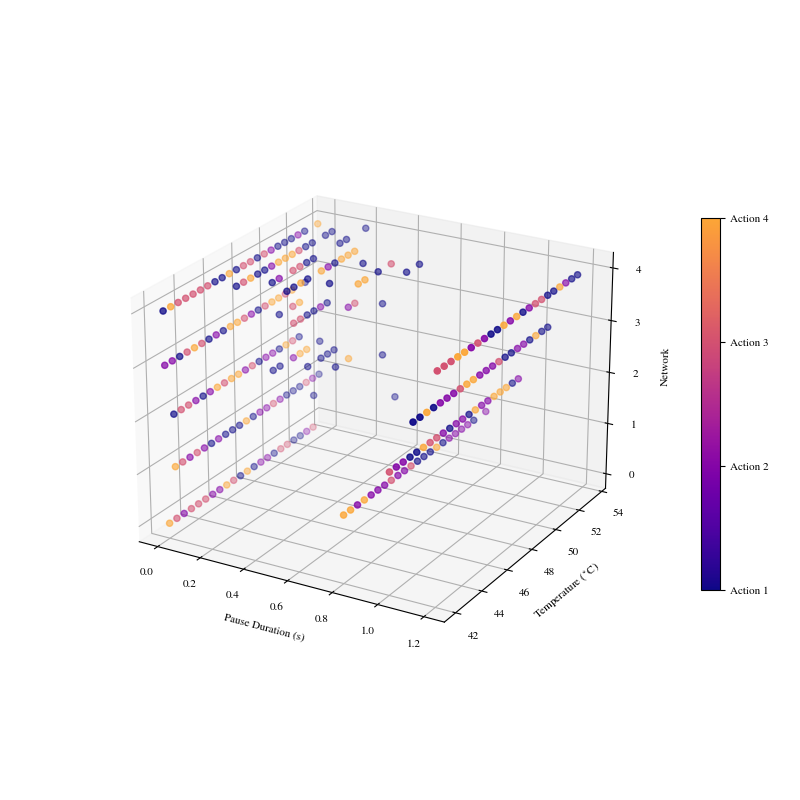

In [7]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
# ax = plt.axes(projection='3d')
ax.view_init(elev=23, azim=-60)
# Data for three-dimensional scattered points
ydata = vis_q_table['Temperature']
xdata = vis_q_table['Pause Duration']
zdata = vis_q_table['Network']
q = ax.scatter3D(xdata, ydata, zdata, c=vis_q_table['Action'], cmap=working_plasma);

net_names = ['EfficientDet-Lite4',
               'EfficientDet-Lite3',
               'EfficientDet-Lite2',
               'EfficientDet-Lite1',
               'EfficientDet-Lite0'
               ]

cbar = fig.colorbar(q,fraction=0.03, pad=0.1)
cbar.set_ticks(range(1,5))
cbar.set_ticklabels(['Action 1', 'Action 2', 'Action 3', 'Action 4'])

ax.set_xlabel('Pause Duration (s)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_zlabel('Network')
ax.set_zticks(range(5))

plot_path = os.path.join(batch_path, "Policy-3D--Device-{}.png".format(device))
plt.savefig(plot_path,bbox_inches="tight", dpi=400)

plot_path = os.path.join(vis_path, "Policy-3D--Device-{}.png".format(device))
plt.savefig(plot_path,bbox_inches="tight", dpi=400)

In [8]:

vis_q_table_pivot[2] = vis_q_table.pivot(index='Pause Duration', columns=['Network', 'Temperature'], values='Action')
vis_q_table_pivot[3] = vis_q_table.pivot(index='Network', columns=['Temperature', 'Pause Duration'], values='Action')


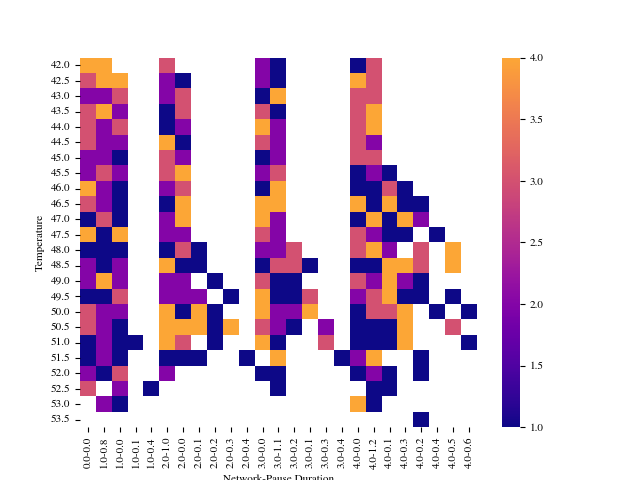

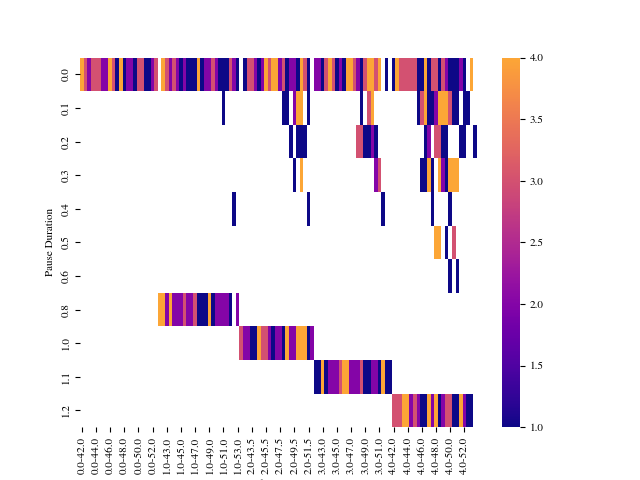

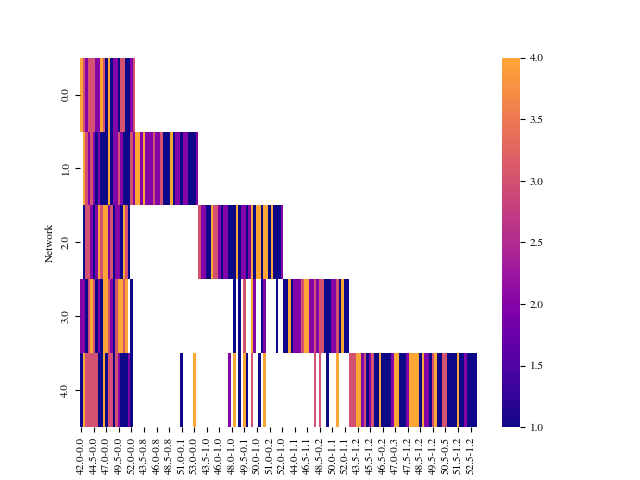

In [9]:
for i in range(1,4) :  
    plt.figure()
    sns.heatmap(vis_q_table_pivot[i], cmap=working_plasma)
    plot_path = os.path.join(batch_path, "Test-Policy-Map-{}--Device-{}.png".format(i, device))
    plt.savefig(plot_path,bbox_inches="tight")

    plot_path = os.path.join(vis_path, "Test-Policy-Map-{}--Device-{}.png".format(i, device))
    plt.savefig(plot_path,bbox_inches="tight")
    plt.show()

In [10]:
test_vis_q_table_pivot = vis_q_table.pivot(index='Temperature', columns=['Network', 'Pause Duration'], values='Action')
test = test_vis_q_table_pivot 
test['Action'] = test[test[].mean(axis=1)
display(test)

SyntaxError: invalid syntax (1110868025.py, line 3)